In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import matplotlib as mpl
font = {"family":"Noto Sans CJK JP"}
mpl.rc('font', **font)

C:\Users\nadare\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# versionの確認
%load_ext watermark
%watermark -u -d -v -iv

json        2.0.9
autopep8    1.3.5
re          2.2.1
numpy       1.15.2
pandas      0.23.4
seaborn     0.8.1
matplotlib  2.1.2
last updated: 2018-10-26 

CPython 3.6.4
IPython 6.2.1


In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
match_df = pd.read_csv("../input/match_reports.csv")
holiday_df = pd.read_csv("../input/holidays_in_japan.csv")
stadium_df = pd.read_csv("../input/stadium_capacity_mapping.csv")
smpsb_df = pd.read_csv("../input/sample_submit.csv", header=None)

# 背景知識

In [4]:
# サッカーの試合をワールドカップ含め見たことがなく、Jリーグのルールもちんぷんかんぷんなのでルールを調べた
# 2018年のおおまかなJリーグの仕組みはここが分かりやすかった
# https://www.jleague.jp/release/post-51912/

# 前処理

In [5]:
# まとめて処理を行いたいので、データフレームを一つにまとめる
target = train_df["attendance"]
total_df = pd.concat([train_df.drop("attendance", axis=1), test_df])

In [6]:
# weather, tempurture, humidityの欠損値は未来のデータ(2018年の33期、34期のもの)
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3843 entries, 0 to 476
Data columns (total 12 columns):
id               3843 non-null int64
match_date       3843 non-null object
kick_off_time    3843 non-null object
section          3843 non-null object
round            3843 non-null object
home_team        3843 non-null object
away_team        3843 non-null object
venue            3843 non-null object
weather          3825 non-null object
temperature      3825 non-null float64
humidity         3825 non-null float64
broadcasters     3843 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 390.3+ KB


## 日付の処理

In [7]:
# datetime型に変換
total_df.loc[:, "match_date"] = pd.to_datetime(total_df["match_date"])
total_df.loc[:, "kick_off_time"] = pd.to_datetime(total_df["kick_off_time"])
holiday_df["holiday_date"] = pd.to_datetime(holiday_df["holiday_date"])

total_df["match_date_year"] = total_df["match_date"].dt.year
total_df["match_date_month"] = total_df["match_date"].dt.month
total_df["match_date_day"] = total_df["match_date"].dt.day
total_df["match_date_dayofweek"] = total_df["match_date"].dt.dayofweek  # Monday=0, Sunday=6

# 祝日の判定
holiday_df["match_date_is_holiday"] = 1
total_df = total_df.merge(right=holiday_df[["holiday_date", "match_date_is_holiday"]],
                          how="left",
                          left_on="match_date",
                          right_on="holiday_date").drop("holiday_date", axis=1)
total_df["match_date_is_holiday"].fillna(0, inplace=True)

total_df["kick_off_time_hour"] = total_df["kick_off_time"].dt.hour
total_df["kick_off_time_minute"] = total_df["kick_off_time"].dt.minute

## 文字列の処理

### 文字→数字(section/round)

In [8]:
total_df.loc[:, "section"] = total_df.loc[:, "section"].apply(lambda x: int(x[1:-1]))
total_df.loc[:, "round"] = total_df.loc[:, "round"].apply(lambda x: int(x[1:-1]))

In [9]:
# 2015年と2016年は2シーズン制
total_df.query("(match_date_year in [2015, 2016])&(section == 1)").iloc[7:12, :]

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,match_date_year,match_date_month,match_date_day,match_date_dayofweek,match_date_is_holiday,kick_off_time_hour,kick_off_time_minute
2761,16810,2015-03-07,2018-10-26 19:04:00,1,1,湘南,浦和,ShonanBMWスタジアム平塚,雨,7.9,66.0,スカパー!/スカパー!プレミアムサービス/NHK BS1,2015,3,7,5,0.0,19,4
2762,16811,2015-03-08,2018-10-26 13:04:00,1,2,清水,鹿島,IAIスタジアム日本平,晴,19.2,45.0,スカパー!/スカパー!プレミアムサービス/テレビ静岡,2015,3,8,6,0.0,13,4
2907,16956,2015-07-11,2018-10-26 18:04:00,1,1,仙台,広島,ユアテックスタジアム仙台,晴,27.0,49.0,スカパー!/スカパー!プレミアムサービス,2015,7,11,5,0.0,18,4
2908,16957,2015-07-11,2018-10-26 19:03:00,1,1,柏,鳥栖,日立柏サッカー場,晴,25.3,73.0,スカパー!/スカパー!プレミアムサービス,2015,7,11,5,0.0,19,3
2909,16958,2015-07-11,2018-10-26 18:30:00,1,1,川崎F,FC東京,等々力陸上競技場,晴,26.1,71.0,スカパー!/スカパー!プレミアムサービス,2015,7,11,5,0.0,18,30


In [10]:
# 両年とも1シーズンに直した時の18節は7月からなので、7月からのsectionを+17する
sec_index = total_df.query("(match_date_year in [2015, 2016])&(match_date_month >= 7)").index
total_df.loc[sec_index, "section"] = total_df.loc[sec_index, "section"] + 17

### team_name

In [11]:
# 半角と全角が混じっている
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

{'札幌', '仙台', '川崎Ｆ', '清水', '山形', '湘南', '長崎', '横浜FC', '京都', '東京V', 'FC東京', '川崎F', '甲府', '磐田', '大分', '松本', '柏', '浦和', 'Ｇ大阪', '新潟', '千葉', 'G大阪', '名古屋', '大宮', '神戸', 'C大阪', '徳島', '横浜FM', '福岡', '鳥栖', 'Ｃ大阪', '鹿島', '広島'}


In [12]:
# まとめて置き換える

def make_zen2han_dic(iterable):
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿−　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_- ")
    z2h = {}
    pattern = "|".join(zen)
    for it in iterable:
        if re.search(pattern, it) is None:
            continue
        target = it*1
        for z, h in zip(zen, han):
            target = target.replace(z, h)
        z2h[it] = target
    return z2h

z2h = make_zen2han_dic(teams)
total_df["home_team"].replace(z2h, inplace=True)
total_df["away_team"].replace(z2h, inplace=True)

In [13]:
teams = set(total_df["home_team"].unique().tolist() + total_df["away_team"].unique().tolist())
print(teams)

{'札幌', '仙台', '清水', '山形', '湘南', '長崎', '横浜FC', '京都', '東京V', 'FC東京', '川崎F', '甲府', '磐田', '大分', '松本', '柏', '浦和', '新潟', '千葉', 'G大阪', '名古屋', '大宮', '神戸', 'C大阪', '徳島', '横浜FM', '福岡', '鳥栖', '鹿島', '広島'}


In [14]:
for team in teams:
    total_df["team_" + team] = (total_df["home_team"] == team) | (total_df["away_team"] == team)

### venue

In [15]:
# value_countsを使うとおかしな値を見つけやすい
# 数回しか出てきていないものには要注意

total_df["venue"].value_counts().sort_values().head(10)

コカ・コーラウエスト広島スタジアム    1
名古屋市瑞穂球技場            1
熊本県民総合運動公園陸上競技場      2
佐賀県総合運動場陸上競技場        3
鹿児島県立鴨池陸上競技場         3
柏の葉公園総合競技場           3
石川県西部緑地公園陸上競技場       4
宮城スタジアム              4
大阪長居第2陸上競技場          5
静岡スタジアムエコパ           7
Name: venue, dtype: int64

In [16]:
# 一応どれもstadium_dfに入っている正式名称らしい
stadium_df_stadium = set(stadium_df["stadium"].tolist())
venue_stadium = set(total_df["venue"].unique().tolist())
print(venue_stadium - stadium_df_stadium)

set()


In [17]:
total_df = total_df.merge(right=stadium_df,
                          how="left",
                          left_on="venue",
                          right_on="stadium").drop("stadium", axis=1)

### weather

In [18]:
# 気象庁の用語集(http://www.jma.go.jp/jma/kishou/know/yougo_hp/toki.html)によると
# のち: 予報期間内の前と後で現象が異なるとき、その変化を示すときに用いる。
# 時々: 現象が断続的に起こり、その現象の発現期間の合計時間が予報期間の1/2未満のとき。
# 一時: 現象が連続的に起こり、その現象の発現期間が予報期間の1/4未満のとき
total_df["weather"].value_counts().head(20)

晴          1907
曇           992
雨           291
屋内          105
曇のち雨         89
晴のち曇         83
雨のち曇         76
曇のち晴         57
曇時々雨         44
曇時々晴         39
晴時々曇         34
曇一時雨         28
晴のち雨         10
雨時々曇          9
晴一時曇          7
晴一時雨          6
曇一時晴          6
雨一時曇          4
雨のち曇一時雨       2
雨一時雷雨         2
Name: weather, dtype: int64

In [19]:
#シンプルに単語を含んでいるか否かで判定(BoWみたい)
for condition in ["晴", "曇", "雨", "屋内", "雷", "雪", "霧", "のち", "時々", "一時"]:
    total_df["weather_{}".format(condition)] = total_df["weather"].str.contains(condition)

### broadcasters

In [20]:
dirty_casters = set()
for casters in total_df["broadcasters"].str.split("/"):
    dirty_casters.update(casters)

In [21]:
# ※以降はチャンネルと関係ない
# スカパー!関連が!がなかったりSportsのスペルや大文字小文字がぐちゃぐちゃになっていて酷い
dirty_casters

{'BS',
 'BS(録)',
 'BS-TBS',
 'BS-TBS(録)',
 'BS-i',
 'BS-i(録)',
 'BS※',
 'BSーTBS',
 'BSーTBS(録)',
 'BSーi',
 'DAZN',
 'DAZN ※AFCチャンピオンズリーグ2017の影響により、G大阪vs鹿島は7月5日(水)に開催',
 'DAZN ※AFCチャンピオンズリーグ2017の影響により、川崎Fvs浦和は7月5日(水)に開催',
 'J SPORTS',
 'J SPORTS ESPN',
 'J SPORTS(録)',
 'J SPORTS2',
 'KBS京都',
 'KBS京都(録)',
 'MXテレビ',
 'MXテレビ(録)',
 'MXテレビ*',
 'NHK BS1',
 'NHK BS1 ※4 AFCチャンピオンズリーグ2016の影響により、浦和vsFC東京は6月22日(水)に開催',
 'NHK BS1 ※6 浦和がスルガ銀行チャンピオンシップ2017SAITAMAに出場のため、7月22日(土)に開催',
 'NHK BS1 ※AFCチャンピオンズリーグ2018の影響により、C大阪vs鹿島は7月25日(水)に開催',
 'NHK BS1(101ch)',
 'NHK BS1(102ch)',
 'NHK BS1(録)',
 'NHK-BSハイビジョン',
 'NHK京都',
 'NHK仙台',
 'NHK仙台 ※ AFCチャンピオンズリーグ2015準決勝の影響により、10月25日(日)に開催。',
 'NHK仙台(東北ブロック)',
 'NHK佐賀',
 'NHK名古屋',
 'NHK名古屋(録)',
 'NHK大分',
 'NHK大阪',
 'NHK大阪(近畿ブロック)',
 'NHK大阪(録)',
 'NHK山形',
 'NHK岐阜',
 'NHK岩手',
 'NHK広島',
 'NHK徳島',
 'NHK新潟',
 'NHK新潟*',
 'NHK札幌',
 'NHK水戸',
 'NHK水戸*',
 'NHK津',
 'NHK甲府',
 'NHK神戸',
 'NHK神戸(近畿ブロック)',
 'NHK神戸(録)',
 'NHK福岡',
 'NHK福島',
 'NHK秋田',
 'NHK総合',
 'NHK総合(録)',
 'NHK長崎',

In [22]:
clean_casters = set()

# ()と※より後ろを消す
# 小文字を大文字に統一
# ーを-に変換する
# スカパー派生は全てスカパーに統一

def cleanify(caster):
    caster = caster.upper()
    caster = re.sub("\(.+\)|\*", "", caster)
    caster = caster.split("※")[0]\
               .rstrip(" ")\
               .replace("ー", "-")\
               .replace(" ", "_")
    if caster[:4] == "スカパ-":
        caster = "スカパー"
    return caster

for caster in dirty_casters:
    clean_casters.add(cleanify(caster))

In [23]:
clean_casters

{'BS',
 'BS-I',
 'BS-TBS',
 'DAZN',
 'E2',
 'E2スカチャン',
 'E2スカチャンHD',
 'J_SPORTS',
 'J_SPORTS2',
 'J_SPORTS_ESPN',
 'KBS京都',
 'MXテレビ',
 'NHK-BSハイビジョン',
 'NHK_BS1',
 'NHK京都',
 'NHK仙台',
 'NHK佐賀',
 'NHK名古屋',
 'NHK大分',
 'NHK大阪',
 'NHK山形',
 'NHK岐阜',
 'NHK岩手',
 'NHK広島',
 'NHK徳島',
 'NHK新潟',
 'NHK札幌',
 'NHK水戸',
 'NHK津',
 'NHK甲府',
 'NHK神戸',
 'NHK福岡',
 'NHK福島',
 'NHK秋田',
 'NHK総合',
 'NHK長崎',
 'NHK長野',
 'NHK青森',
 'NHK静岡',
 'RKB毎日放送',
 'TBS',
 'TOKYO_MX',
 'TOKYO_MX2',
 'TVK',
 'TVQ九州放送',
 'ひかりTV',
 'サンテレビ',
 'スカイパ-フェクTV!',
 'スカパー',
 'テレビ信州',
 'テレビ北海道',
 'テレビ埼玉',
 'テレビ大分',
 'テレビ大阪',
 'テレビ山梨',
 'テレビ新潟',
 'テレビ神奈川',
 'テレビ西日本',
 'テレビ静岡',
 'テレ玉',
 'ミヤギテレビ',
 '中京テレビ',
 '中国放送',
 '中部日本放送',
 '九州朝日放送',
 '仙台放送',
 '信越放送',
 '北海道テレビ',
 '北海道テレビ放送',
 '北海道放送',
 '北海道文化放送',
 '千葉テレビ',
 '名古屋テレビ',
 '大分朝日放送',
 '山梨放送',
 '新潟テレビ21',
 '新潟放送',
 '新潟総合テレビ',
 '日本テレビ',
 '朝日放送',
 '札幌テレビ',
 '札幌テレビ放送',
 '東北放送',
 '東日本放送',
 '東海テレビ',
 '毎日放送',
 '福岡放送',
 '長崎国際テレビ',
 '長野放送',
 '長野朝日放送',
 '関西テレビ',
 '静岡放送',
 '静岡朝日テレビ',
 '静岡第一テレビ'}

In [24]:
tmp = total_df["broadcasters"].str.split("/")\
                              .apply(lambda casters: [cleanify(caster) for caster in casters])
total_df["broadcasters"] = tmp

In [25]:
for caster in clean_casters:
    total_df["broadcasters_{}".format(caster)] = total_df["broadcasters"].apply(lambda casters: caster in casters)


In [26]:
# 30個未満のは消してよい気がする
# EDAの #atodekesu
#caster_counts = total_df.filter(regex="broadcasters_").sum(axis=0)
#total_df.drop(caster_counts[caster_counts < 30].index.tolist(), axis=1, inplace=True)

## match_dfと結合

In [27]:
# 選手名とかポジションとかよくわからないので
# 点数と勝敗だけいれる

match_df["home_team_win"] = match_df["home_team_score"] > match_df["away_team_score"]
total_df = total_df.merge(match_df[["id", "home_team_win", "home_team_score", "away_team_score"]],
                          how="left",
                          on="id")

In [28]:
# 欠損値はいったん考えないこととする
total_df = total_df.dropna()

# EDA

## match_date/kick_off_time

Text(0.5,1,'kick_off_time hour')

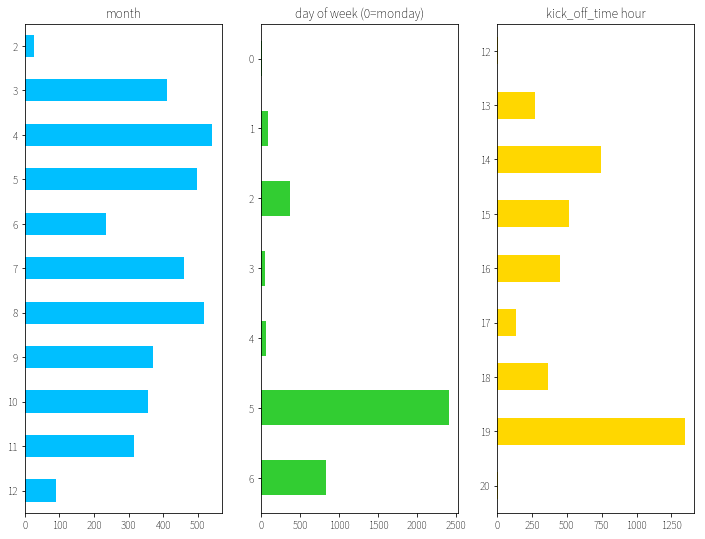

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs = axs.flatten()
total_df["match_date_month"].value_counts()\
                            .sort_index(ascending=False)\
                            .plot(kind="barh", ax=axs[0], color="deepskyblue")
axs[0].set_title("month")

total_df["match_date_dayofweek"].value_counts()\
                                .sort_index(ascending=False)\
                                .plot(kind="barh", ax=axs[1], color="limegreen")
axs[1].set_title("day of week (0=monday)")

total_df["kick_off_time_hour"].value_counts()\
                                .sort_index(ascending=False)\
                                .plot(kind="barh", ax=axs[2], color="gold")
axs[2].set_title("kick_off_time hour")

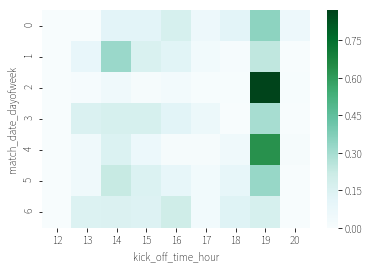

In [30]:
# 曜日ごとにどの時間に始まりやすいかを集計
# 平日はナイターが多く、土日は分散している？
# 追記: 夏は夜、冬は昼間に試合を行うことが多いようだ

pivot = total_df.pivot_table(index="match_date_dayofweek",
                             columns="kick_off_time_hour",
                             values="id",
                             aggfunc="count").fillna(0)
pivot =  pivot / (pivot.sum(axis=1).values.reshape(-1, 1) * np.ones((1, 9)))
sns.heatmap(pivot, cmap="BuGn")

(0, 1)

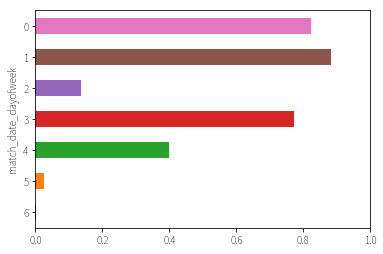

In [31]:
# 曜日のうち休日の割合
# 水曜日は休日が少なく、ナイターの割合が多い
total_df.groupby("match_date_dayofweek")["match_date_is_holiday"]\
        .mean()\
        .sort_index(ascending=False)\
        .plot(kind="barh")

plt.xlim(0, 1)

## team/stadium

In [32]:
# 試合数の合計
# 浦和や鹿島は長年Jリーグにいるようで僕でも聞いたことがある
total_df.filter(regex="^team").sum(axis=0)

team_札幌      119
team_仙台      289
team_清水      391
team_山形      136
team_湘南      153
team_長崎       17
team_横浜FC     34
team_京都      136
team_東京V      34
team_FC東京    391
team_川崎F     425
team_甲府      272
team_磐田      357
team_大分      170
team_松本       34
team_柏       357
team_浦和      425
team_新潟      408
team_千葉      136
team_G大阪     391
team_名古屋     391
team_大宮      374
team_神戸      357
team_C大阪     255
team_徳島       34
team_横浜FM    425
team_福岡      102
team_鳥栖      221
team_鹿島      425
team_広島      391
dtype: int64

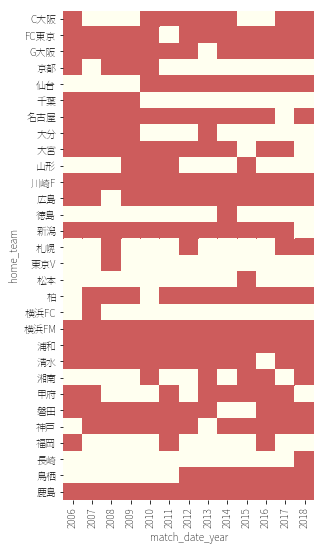

In [33]:
# 開催年と出場状況
#赤が出場している年
plt.figure(figsize=(4.5, 9))
pivot = total_df.pivot_table(columns="match_date_year",
                             index="home_team",
                             values="id",
                             aggfunc="any").fillna(0).astype(np.int16)
sns.heatmap(pivot, cmap=["ivory", "indianred"], cbar=False)

In [34]:
# チームごとのホームスタジアム
home_stadium_df = total_df.groupby(["home_team", "venue"])["id"].any().reset_index().drop("id", axis=1)
home_stadium_df.head(15)

,home_team,venue
0,C大阪,キンチョウスタジアム
1,C大阪,ヤンマースタジアム長居
2,C大阪,大阪長居スタジアム
3,C大阪,大阪長居第2陸上競技場
4,FC東京,味の素スタジアム
5,FC東京,国立競技場
6,FC東京,松本平広域公園総合球技場
7,G大阪,パナソニックスタジアム吹田
8,G大阪,万博記念競技場
9,G大阪,市立吹田サッカースタジアム


In [35]:
# 12会場が複数のチームにホームグラウンドとして使われている
home_stadium_df["venue"].value_counts().sort_values(ascending=False).head(12)

国立競技場             9
松本平広域公園総合球技場      3
エコパスタジアム          2
鹿児島県立鴨池陸上競技場      2
静岡スタジアムエコパ        2
味の素スタジアム          2
さいたま市浦和駒場スタジアム    2
横浜市三ツ沢公園球技場       2
埼玉スタジアム2002       2
県立カシマサッカースタジアム    2
日産スタジアム           2
名古屋市瑞穂球技場         1
Name: venue, dtype: int64

In [36]:
# 各チームどれくらいのホームスタジアムを使っているのか
home_stadium_df.groupby("home_team")["venue"].count().value_counts().sort_index()

1     5
2    10
3     5
4     9
6     1
Name: venue, dtype: int64

## broadcasters

In [37]:
# チームと放送チャンネルの関係を見る
team_broadcast = {team:{caster: False for caster in clean_casters} for team in teams}

In [38]:
broadcasters_col = ["broadcasters_{}".format(caster) for caster in clean_casters]
for team in teams:
    team_appear = (total_df["home_team"] == team) | (total_df["away_team"] == team)
    tmp_df = total_df.loc[team_appear, broadcasters_col]
    for caster in clean_casters:
        if tmp_df["broadcasters_{}".format(caster)].any():
            team_broadcast[team][caster] = True

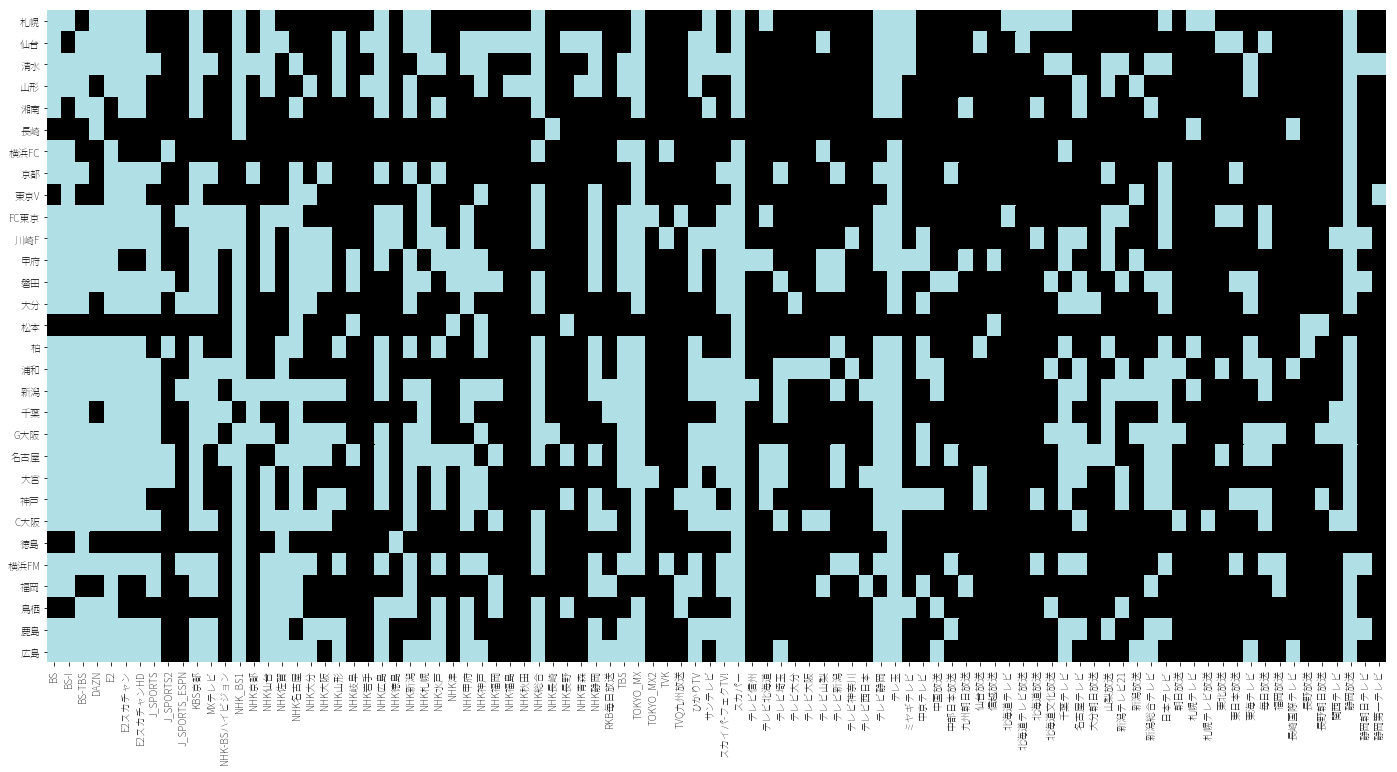

In [39]:
# 水色が放送したことのある組み合わせ
plt.figure(figsize=(24, 12))
sns.heatmap(pd.DataFrame(team_broadcast).T.astype(np.int64),
            cbar=False,
            cmap=["k", "powderblue"])

## 目的変数との関係

In [40]:
total_df = total_df.dropna()
train_df = total_df.query("id < 19075")
train_df.loc[:, "attendance"] = target.values
test_df = test_df.query("id >= 19075")

C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


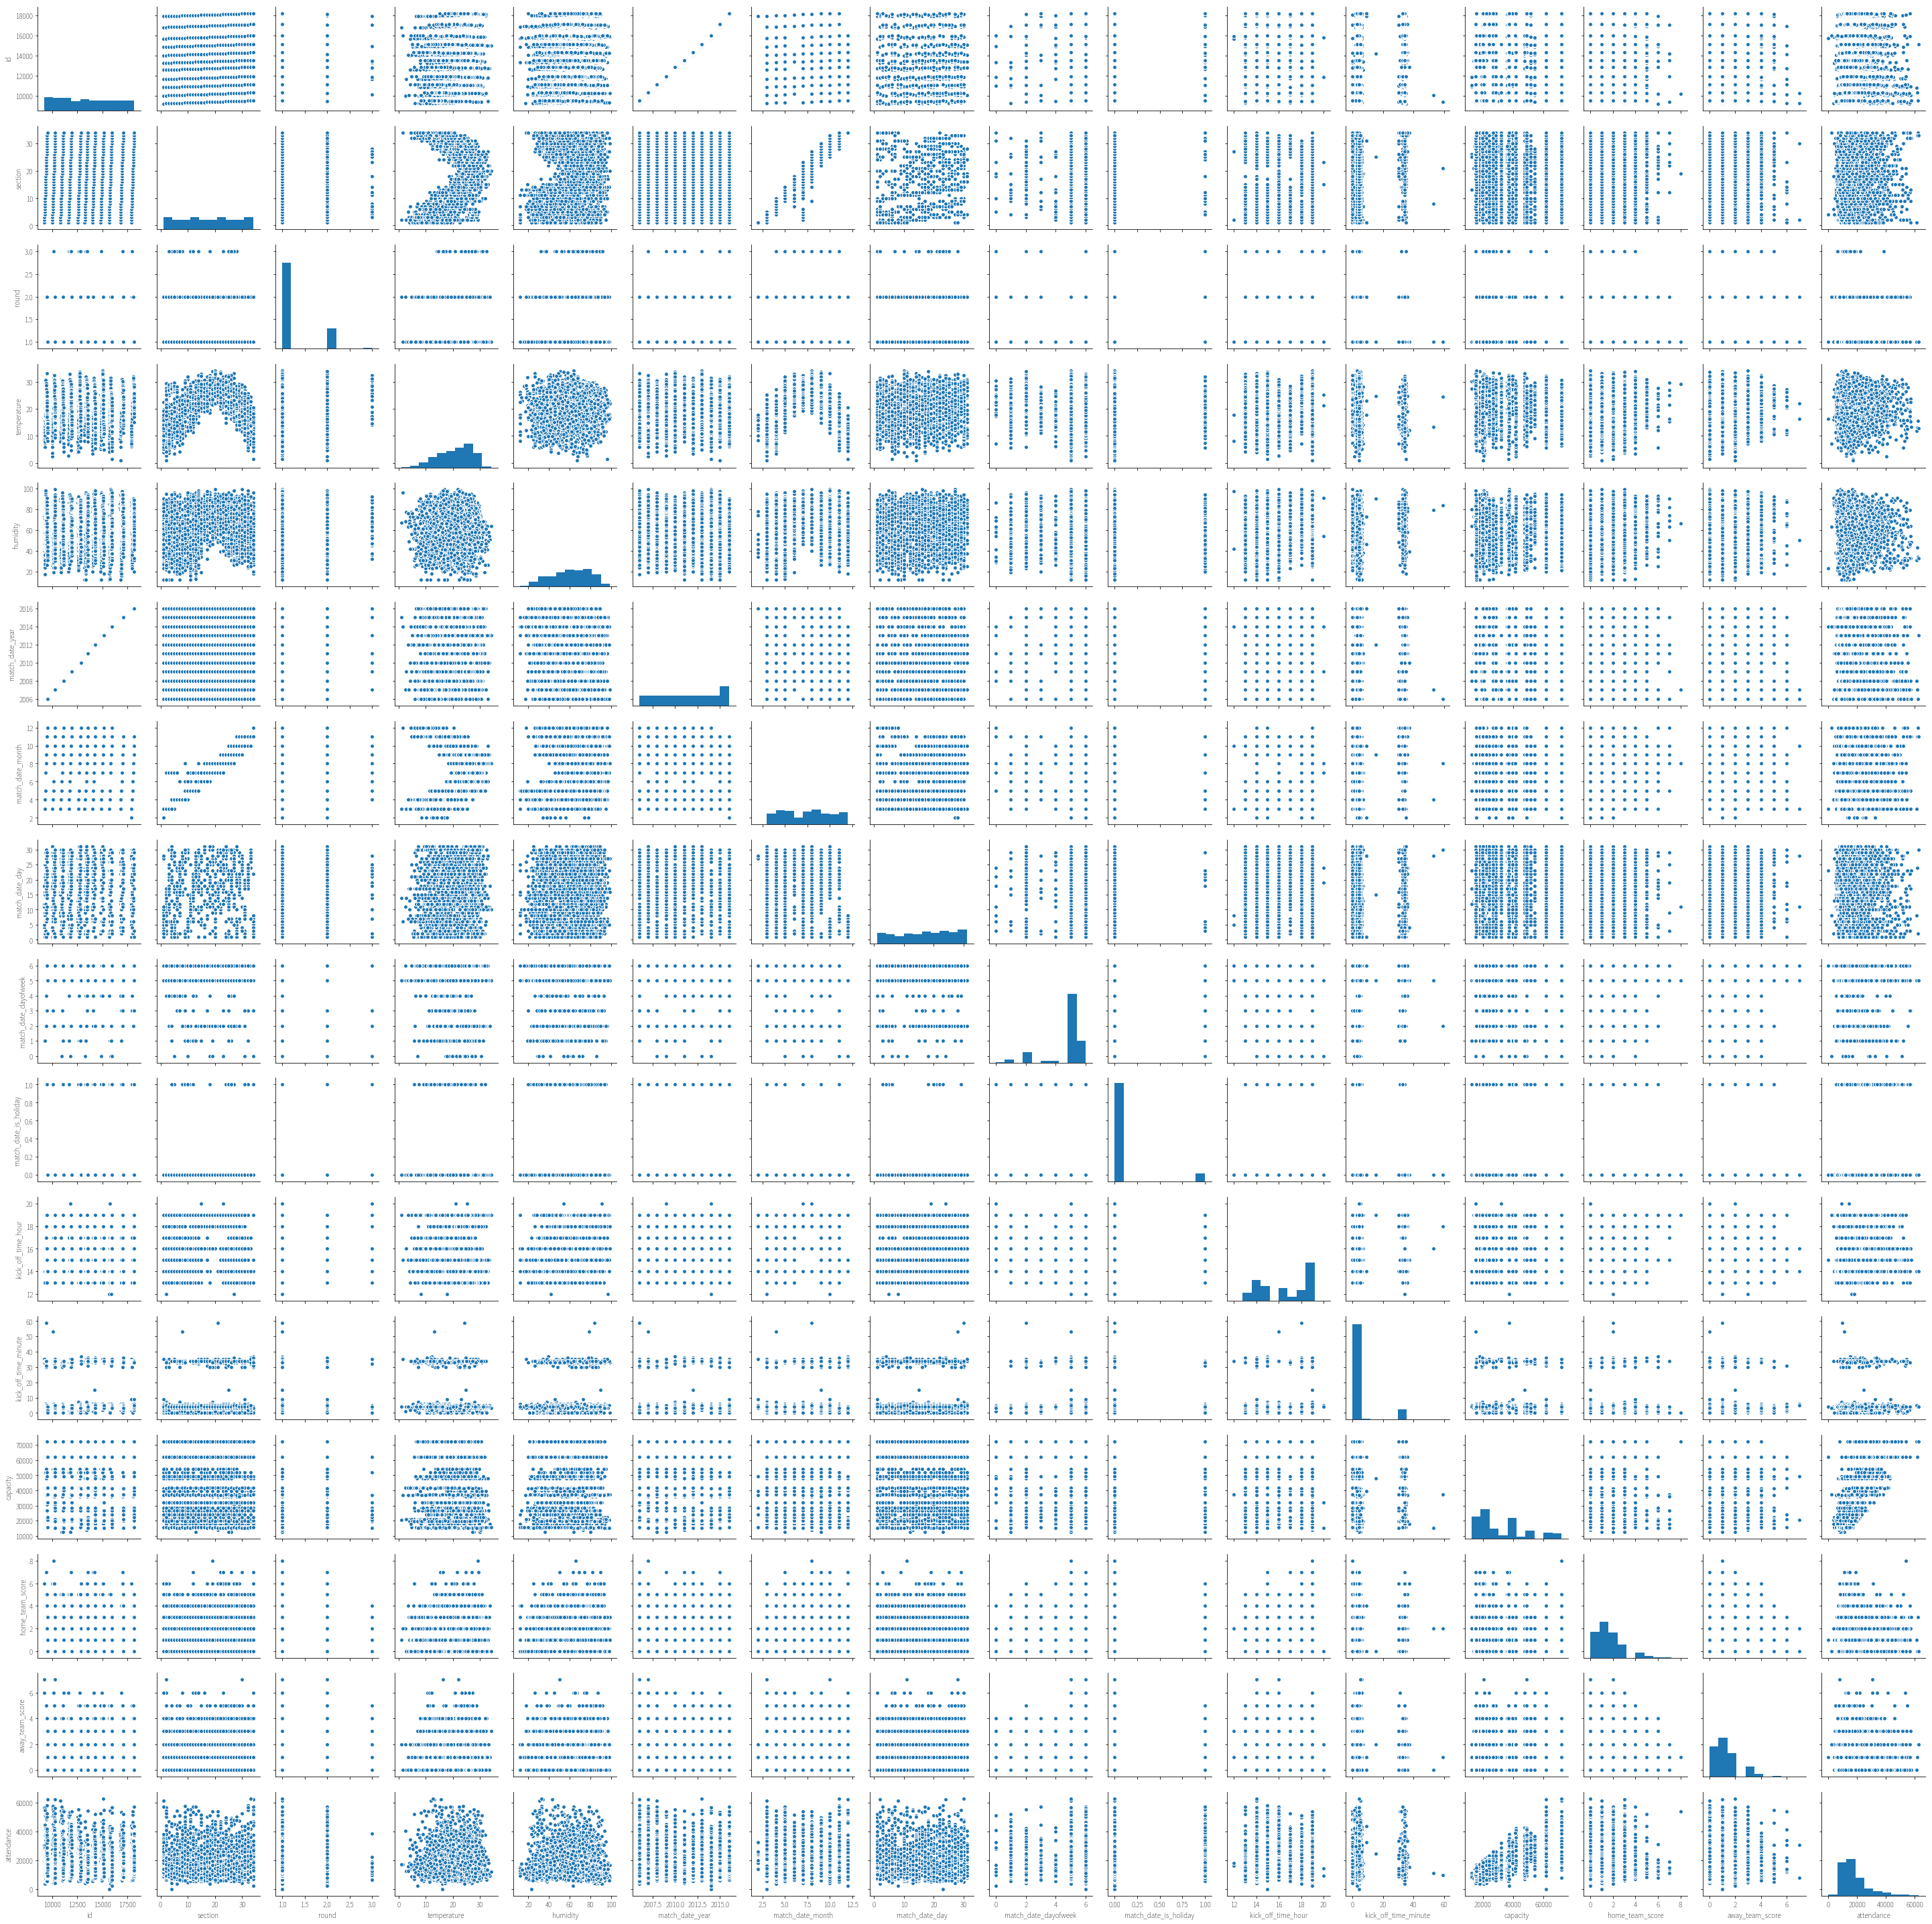

In [41]:
# 全体の相関
# やや実行時間がかかる
# 直接相関がありそうなのはcapacityくらいか？

sns.pairplot(train_df.select_dtypes([np.int64, np.float64]))

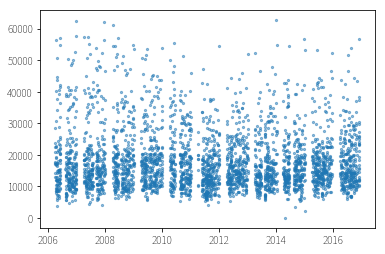

In [42]:
# 時系列プロット
# 時系列的な影響は少なそう
# 2014年に観客数の少ない回がある
x = train_df["match_date_year"] + train_df["match_date_month"] / 12 + train_df["match_date_day"] / 365
y = train_df["attendance"]
plt.scatter(x, y, alpha=0.5, s=5)

In [43]:
# 2014/3/23の試合は観客数が0人だった
# 検索してみると2014/3/8にファンが問題を起こしたらしく、それを運営も放置したので罰として次の試合が無観客試合となったらしい
# wikipediaのページ『浦和レッズ差別横断幕事件』
# https://ja.wikipedia.org/wiki/%E6%B5%A6%E5%92%8C%E3%83%AC%E3%83%83%E3%82%BA%E5%B7%AE%E5%88%A5%E6%A8%AA%E6%96%AD%E5%B9%95%E4%BA%8B%E4%BB%B6

train_df.query("attendance <= 5000")[["match_date", "home_team", "away_team", "venue", "attendance", "capacity"]]

,match_date,home_team,away_team,venue,attendance,capacity
48,2006-04-02,京都,福岡,京都市西京極総合運動公園陸上競技場兼球技場,3670,20588
182,2006-08-30,大宮,福岡,さいたま市浦和駒場スタジアム,4873,21500
387,2007-05-06,横浜FC,神戸,横浜市三ツ沢公園球技場,4458,15440
414,2007-05-26,横浜FC,大分,横浜市三ツ沢公園球技場,4935,15440
569,2007-10-27,横浜FC,大宮,横浜市三ツ沢公園球技場,4114,15440
1564,2011-07-13,福岡,大宮,レベルファイブスタジアム,4028,22331
2479,2014-03-23,浦和,清水,埼玉スタジアム2002,0,62010
2608,2014-08-02,徳島,甲府,鳴門・大塚スポーツパークポカリスエットスタジアム,3594,17924
2749,2014-12-08,新潟,柏,県立カシマサッカースタジアム,2104,37496


# モデリング

## データの準備

In [44]:
# 今回は欠損値に関して考えないものとする
total_df = total_df.dropna()
bool_col = total_df.filter(regex="^weather_").columns.tolist() + ["home_team_win"]
total_df.loc[:, bool_col] = total_df.loc[:, bool_col].astype(np.bool8)

In [45]:
# objectとdatetimeは直接扱えないので取り除く
del_col = total_df.select_dtypes(["object", np.datetime64]).columns
total_df.drop(del_col, axis=1, inplace=True)

In [46]:
# 全体の1%に満たないbool値は消す
threshold = 0.01
bool_df = total_df.select_dtypes("bool")
del_col = (bool_df.sum(axis=0)[bool_df.sum(axis=0) <= train_df.shape[0] * threshold]).index.tolist()
total_df.drop(del_col, axis=1, inplace=True)

In [47]:
total_df = total_df.dropna()
train_df = total_df.query("id < 19075")
train_df.loc[:, "attendance"] = target.values
train_df.drop(2479, inplace=True)  # 無観客試合
test_df = total_df.query("id >= 19075")

C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\nadare\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

## hold-out検証

In [48]:
# 今回は時系列データなので、ある期間との前後でデータを分ける
# 2015年までのデータを訓練データ
# 2016年のデータを検証用データにする
# 評価関数はRMSLEなので、あらかじめ目的変数のlogをとっておく

all_train_X = train_df.query("match_date_year <= 2016").drop(["id", "attendance"], axis=1)
all_train_y = np.log1p(train_df.query("match_date_year <= 2016")["attendance"])

train_X = train_df.query("match_date_year <= 2015").drop(["id", "attendance"], axis=1)
train_y = np.log1p(train_df.query("match_date_year <= 2015")["attendance"])

val_X = train_df.query("match_date_year == 2016").drop(["id", "attendance"], axis=1)
val_y = np.log1p(train_df.query("match_date_year == 2016")["attendance"])

test_X = test_df.drop(["id"], axis=1)

## random forestによる予測

In [49]:
# みんな大好きrandomforest
# 無調整だが、十分いいスコアが出た
# ただし、過学習気味なので正則化を考えたい

rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=2434)

rfr.fit(train_X, train_y)
train_pred = rfr.predict(train_X)
val_pred = rfr.predict(val_X)

print("train_score: {:<.5}".format(np.sqrt(mean_squared_error(train_y, train_pred))))
print("val_score: {:<.5}".format(np.sqrt(mean_squared_error(val_y, val_pred))))

train_score: 0.085515
val_score: 0.24454


<Container object of 73 artists>

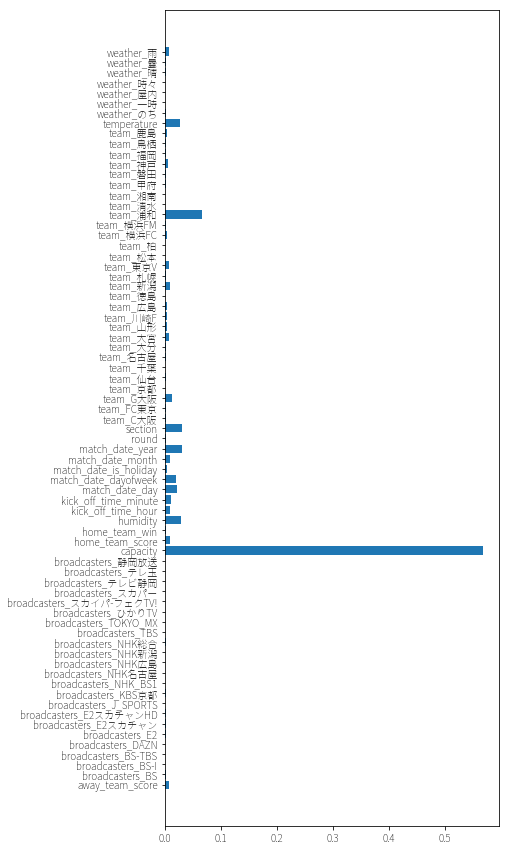

In [50]:
# どの特徴量が有効だったか確認
# capacityが特徴量として一番効いている
plt.figure(figsize=(6, 15))
plt.barh(train_X.columns, rfr.feature_importances_)

In [51]:
# みんな大好きrandomforest
# 無調整だが、十分いいスコアが出た
# ただし、過学習気味なので正則化を考えたい

rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=2434, max_features=.3)

rfr.fit(train_X, train_y)
train_pred = rfr.predict(train_X)
val_pred = rfr.predict(val_X)

print("train_score: {:<.5}".format(np.sqrt(mean_squared_error(train_y, train_pred))))
print("val_score: {:<.5}".format(np.sqrt(mean_squared_error(val_y, val_pred))))

train_score: 0.085534
val_score: 0.24762


## 結果の解釈

<Container object of 73 artists>

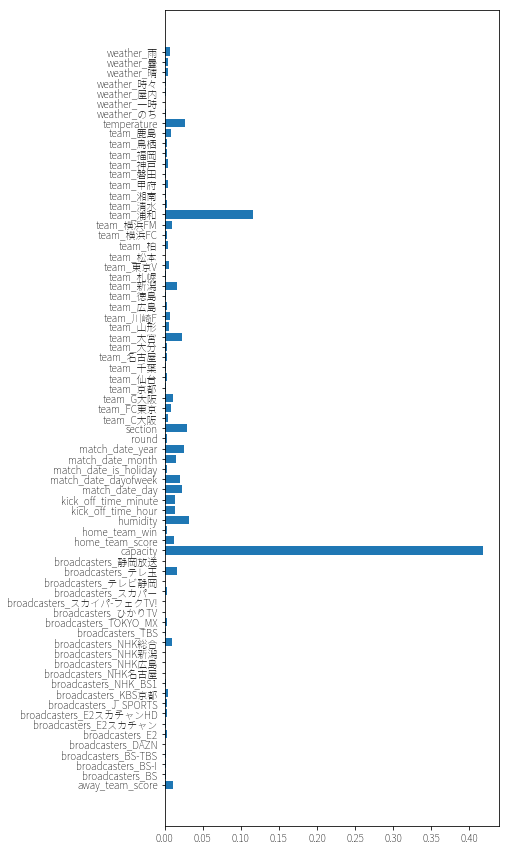

In [54]:
# どの特徴量が有効だったか確認
# capacityが特徴量として一番効いている
plt.figure(figsize=(6, 15))
plt.barh(train_X.columns, rfr.feature_importances_)

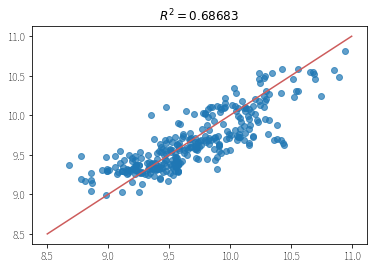

In [108]:
#validationのずれを確認する
from sklearn.metrics import r2_score
plt.scatter(val_y, val_pred, alpha=0.7)
plt.title("$R^2 = {:<.5}$".format(r2_score(val_y, val_pred)))
x = np.linspace(8.5, 11, 100)
plt.plot(x, x, c="indianred")

## 結果の提出

In [109]:
# 改めて全訓練データで予測

rfr.fit(all_train_X, all_train_y)
test_pred = rfr.predict(test_X)
smpsb_df.iloc[:len(test_X), 1] = np.expm1(rfr.predict(test_X)) 

In [110]:
# コードの提出
# LBでのスコアは0.25650だったのでholdout検証の結果とそこまでずれていないようだ
smpsb_df.to_csv("../output/tutorial_result2.csv", index=None, header=None)